# Process the IAD dataset
This cleans and standardizes the IAD dataset attributes and collects all images into a single h5 file.

In [1]:
import pandas as pd
from os import path

In [2]:
base_dir = '/src/dermosxai/data/IAD'
image_dir = path.join(base_dir, 'images')
attrs_sheet = path.join(base_dir, 'IAD_original.csv')

# Read data from excel (from Sergios)

In [3]:
df = pd.read_csv(attrs_sheet)
df

,No.,Diagnosis,Global pattern,Location,records found,Age,certainty,Diameter,Dots Globules,Elevation,...,management,No. progressivo,Note,Other criteria,Pigment network,Pigmentation,Regression C,Sex,Streaks,Vascular pattern
0,na7-5-4-6,Melanoma (less than 0.76 mm),multicomponent pattern,back,1011,32,low,20.0,irregular,palpable,...,excision,1a7546,NaN,absent,atypical,diffuse irregular,combinations,female,irregular,absent
1,nd6-5,Clark nevus,cobblestone pattern,back,1011,30,medium,8.0,regular,palpable,...,excision,1d65,NaN,absent,typical,absent,blue areas,female,absent,absent
2,nd76-75,Reed/Spitz nevus,starburst pattern,upper limbs,1011,22,high,9.0,irregular,palpable,...,excision,1d7675,NaN,absent,atypical,absent,absent,male,regular,absent
3,na19-20,Melanoma (in situ),multicomponent pattern,upper limbs,1011,33,low,7.0,irregular,palpable,...,excision,1a1920,NaN,absent,absent,absent,combinations,female,irregular,absent
4,na3-2-1,Melanoma (0.76 - 1.5 mm),multicomponent pattern,acral,1011,51,low,40.0,irregular,palpable,...,excision,1a321,NaN,absent,absent,diffuse irregular,absent,male,irregular,"linear, irregular"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1006,new48-49,Melanoma (less than 0.76 mm),multicomponent pattern,lower limbs,1011,56,low,14.0,irregular,palpable,...,excision,1e4849,NaN,absent,atypical,diffuse irregular,absent,female,irregular,absent
1007,new50-51,Melanoma (less than 0.76 mm),multicomponent pattern,lower limbs,1011,41,low,24.0,irregular,palpable,...,excision,1e5051,NaN,absent,atypical,absent,combinations,male,absent,absent
1008,new52-53,Melanoma (in situ),reticular pattern,head-neck,1011,76,medium,23.0,absent,flat,...,excision,1e5253,The dermoscopic clue for the diagnosis of this...,absent,atypical,absent,combinations,male,absent,within regression
1009,new54-55,Melanoma (0.76 - 1.5 mm),multicomponent pattern,lower limbs,1011,73,low,18.0,irregular,palpable,...,excision,1e5455,NaN,absent,atypical,diffuse irregular,absent,female,irregular,dotted


# Get image filenames
Pretty ad hoc but image filenames were not standardized.

In [4]:
filenames = df['No.']

In [5]:
def split_name(s):
    """ Divide original identifier (e.g. nd76-75) into a base 'nd' and rest '76-75'"""
    # Drop any whitespace
    s = s.replace(' ', '')
    
    # Find first number
    for i, c in enumerate(s):
        if c.isdigit():
            break
    base, rest = s[:i], s[i:]
    
    # Fix when the letters and numbers have a dash in between
    if base[-1] == '-':
        base = base[:-1]
        
    return pd.Series([base, rest], index=['base', 'rest'])

filenames = pd.concat([filenames, filenames.apply(split_name)], axis=1)

In [6]:
# Divide each image_id to be its own row (e.g "76-75" will become two rows one with 76 and one with 75)
new_rows = []
for i, row in filenames.iterrows():
    for id_ in row['rest'].split('-'):
        new_row = row.to_dict()
        new_row['image_id'] = id_.strip()
        new_rows.append(new_row)
        
filenames = pd.DataFrame(new_rows)

In [7]:
def get_folder(row):
    """ Map from base name (e.g., 'nd') to the name of the folder that it represents. Essentially a dictionary."""
    folder_name = row['base'] + 'l'
    if row['base'] == 'aa':
        image_id = row['image_id'][:-3] if row['image_id'].endswith(('bis', 'BIS')) else row['image_id']
        digit = min(int(image_id) // 100 + 1, 5)
        folder_name = f'A{digit}l'
    if row['base'] in ['fa', 'fb', 'fc', 'fd', 'fe', 'ff', 'na', 'nb', 'nc', 'nd', 'ne', 'nf', 'ng', 'nh', 'ni', 'nl', 'nm']:
        folder_name = folder_name.upper()
    elif row['base'] in ['fg', 'fh', 'fi', 'fl', 'fm', 'ga', 'gb', 'gc', 'gd', 'gg', 'gz', 'new']:
        folder_name = folder_name.capitalize()

    return folder_name

filenames['base'] = filenames['base'].str.lower() # make base name lowercase
filenames['folder'] = filenames.apply(get_folder, axis=1)

In [8]:
import glob

def get_filename(row):
    """Transform the imadge id into the expected image filename, find if an image with that name exists in the right folder, 
    and return the filename of the image. """
    # Get padded image_id
    image_id = row['image_id']
    pad_amount = 2 if row['base'] == 'gz' else 3
    padded_id = f'{int(image_id[:-3]):0{pad_amount}}{image_id[-3:]}' if image_id.endswith(('bis', 'BIS')) else f'{int(image_id):0{pad_amount}}'
    
    # Get filename
    filenames = glob.glob(path.join(image_dir, row['folder'], f'*{padded_id}.[jJ][pP][gG]'))
    if len(filenames) == 0:
        #print(f'Warning: No matching image for {row}')
        filename = None
    elif len(filenames) == 1:
        filename = path.basename(filenames[0])
    else:
        raise ValueError('More than one matching image')
    
    return filename

filenames['filename'] = filenames.apply(get_filename, axis=1)

In [9]:
# Drop images in the filename that could not be found in the provided data
print(len(filenames[filenames['filename'].isnull()]), 'missing filenames.') 
filenames = filenames.dropna()

135 missing filenames.


In [10]:
filenames

,No.,base,rest,image_id,folder,filename
0,na7-5-4-6,na,7-5-4-6,7,NAL,Nal007.jpg
1,na7-5-4-6,na,7-5-4-6,5,NAL,Nal005.jpg
2,na7-5-4-6,na,7-5-4-6,4,NAL,Nal004.jpg
3,na7-5-4-6,na,7-5-4-6,6,NAL,Nal006.jpg
4,nd6-5,nd,6-5,6,NDL,Ndl006.jpg
...,...,...,...,...,...,...
2041,new52-53,new,52-53,53,Newl,newl053.jpg
2042,new54-55,new,54-55,54,Newl,newl054.jpg
2043,new54-55,new,54-55,55,Newl,newl055.jpg
2044,new58-59,new,58-59,58,Newl,newl058.jpg


In [11]:
# Count number of images per patient
print('Number of patients with x amount of images:')
filenames[['No.', 'base']].groupby('No.').count()['base'].value_counts()

Number of patients with x amount of images:


2    870
1     89
3     26
4      1
Name: base, dtype: int64

# Process attributes

## Restrict data frame to ids with at least one image

In [12]:
df = df[df['No.'].isin(filenames['No.'])]

## Drop non-relevant attributes
We drop No. progressivo (an id that is irrelevant, real id is called No.) and records found which just always says 1011. 

In [13]:
df = df.drop(['No. progressivo', 'records found'], axis='columns')

## Standardize column names (and categorical contents)

In [14]:
# drop the . from the end of some attributes, make snake_case
df.columns = df.columns.str.lower().str.replace('.', '', regex=False).str.replace(' ', '_')
filenames.columns = filenames.columns.str.lower().str.replace('.', '', regex=False).str.replace(' ', '_')

In [15]:
# these say "xxxxxxxx pattern" where xxxxxx is the actual value, I drop " pattern"
df['global_pattern'] = df['global_pattern'].str.replace(' pattern', '')

# drop the comma from "linear, irregular" -> "linear irregular"
df['vascular_pattern'] = df['vascular_pattern'].str.replace(',', '')

# make lowercase, drop parenthesis and replace dash with "to"
df['diagnosis'] = df['diagnosis'].str.lower().str.replace('(', '', regex='False').str.replace(')', '', regex=False).str.replace('-', 'to').str.replace(' mm', 'mm')

In [16]:
# replace spaces with underscores (e.g., "upper limbs" or "no further examination")
columns = ['location', 'management', 'other_criteria', 'pigmentation', 'regression_c', 'vascular_pattern', 'diagnosis']
for col in columns:
    df[col] = df[col].str.replace(' ', '_')

## Randomize patients
To make sure they are not ordered in any particular way and ease train/val/test splitting later.

In [17]:
df = df.sample(frac=1, random_state=1234).reset_index(drop=True)

## Add integer patient id

In [18]:
df['patient_id'] = range(len(df))

# Add it to filenames too
filenames = pd.merge(filenames, df[['no', 'patient_id']], on='no')
filenames = filenames.sort_values(['patient_id', 'image_id'], ignore_index=True)

# Save results

In [19]:
df.to_csv(path.join(base_dir, 'IAD_metadata.csv'), index=False) # save names of each categorical value somehow
filenames.to_csv(path.join(base_dir, 'IAD_filenames.csv'), index=False)

In [20]:
df

,no,diagnosis,global_pattern,location,age,certainty,diameter,dots_globules,elevation,gray_blue_areas,...,management,note,other_criteria,pigment_network,pigmentation,regression_c,sex,streaks,vascular_pattern,patient_id
0,ni99-100,melanoma_less_than_0.76mm,reticular,chest,62,high,15.0,irregular,flat,absent,...,excision,NaN,absent,atypical,absent,white_areas,male,absent,within_regression,0
1,AA451-452-453,clark_nevus,reticular,back,36,high,6.0,regular,flat,absent,...,excision,This type of Clark nevus with focal hyperpigme...,absent,atypical,localized_irregular,absent,female,absent,absent,1
2,nb14-15,melanoma_in_situ,multicomponent,back,48,low,14.0,irregular,palpable,present,...,excision,NaN,absent,typical,diffuse_irregular,absent,female,absent,absent,2
3,nd53-54,reed/spitz_nevus,starburst,chest,25,low,5.0,regular,palpable,absent,...,excision,NaN,absent,typical,diffuse_regular,absent,female,regular,absent,3
4,FB 31-32,blue_nevus,homogeneous,lower_limbs,32,high,8.0,absent,nodular,absent,...,excision,NaN,absent,absent,diffuse_irregular,absent,female,absent,absent,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
981,ng3-4,melanoma_0.76_to_1.5mm,multicomponent,lower_limbs,47,medium,12.0,irregular,palpable,present,...,excision,NaN,absent,absent,absent,absent,female,absent,dotted,981
982,nb45-46,melanoma_metastasis,unspecific,lower_limbs,62,high,5.0,regular,nodular,absent,...,excision,NaN,absent,absent,diffuse_irregular,absent,female,absent,hairpin,982
983,nl13-14,melanoma_0.76_to_1.5mm,multicomponent,abdomen,58,medium,16.0,irregular,palpable,present,...,excision,NaN,absent,absent,absent,combinations,male,absent,linear_irregular,983
984,FE 37-38,reed/spitz_nevus,multicomponent,lower_limbs,10,high,12.0,irregular,palpable,present,...,excision,This globular type of Spitz nevus is both clin...,absent,absent,diffuse_irregular,absent,male,irregular,dotted,984


# Create a h5 dset with all images
Images have different sizes (but mostly 512/768, i.e. 3:2 ratio)  and sometimes have a black band around the image.

In [21]:
#matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
from os import path

In [22]:
base_dir = '/src/dermosxai/data/IAD'
image_dir = path.join(base_dir, 'images')
filenames_path = path.join(base_dir, 'IAD_filenames.csv')

## Read all images in order

In [23]:
import pandas as pd

filenames = pd.read_csv(filenames_path)
image_paths = filenames.apply(lambda row: path.join(image_dir, row['folder'], row['filename']), axis=1)

In [24]:
from PIL import Image

def load_Image(filename):
    """ Opens and loads a PIL Image"""
    image = Image.open(filename)
    image.load()  # read data and close file descriptor
    return np.array(image)

In [25]:
ims = []
for image_path in image_paths:
    ims.append(load_Image(image_path))

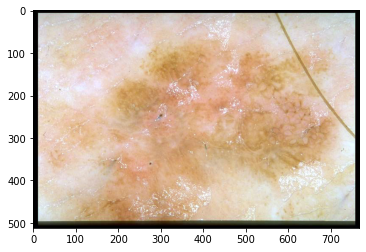

In [26]:
plt.imshow(ims[0])

## Get rid of the black bands around the edge of some images

In [29]:
from dermosxai import utils

In [30]:
cropped_ims = [utils.crop_black_edges(im) for im in ims]

## Crop images to match 4:3 ratio (rather than ~3:2 current ratio)

In [31]:
rescaled_ims = [utils.crop_to_ratio(im) for im in cropped_ims]

## Resize images to final 150 x 200 pixels

In [32]:
resized_ims = [np.array(Image.fromarray(im).resize((200, 150), resample=Image.LANCZOS, reducing_gap=3)) for im in rescaled_ims]

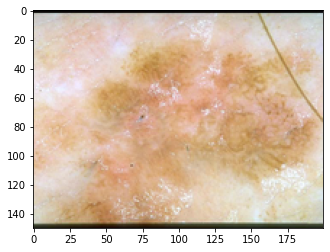

In [33]:
plt.imshow(resized_ims[0])

## Reorder images so we have a list (of size num_patients) of 4-d arrays (num_images_per_patient x 150 x 200 x 3)
Warning: this assumes that patient_ids in filenames come ordered.

In [34]:
final_ims = np.stack(resized_ims) # num_patients*num_images_per_patient x h x w x 3

In [35]:
idx = 0
grouped_ims = []
for num_images_per_patient in filenames.groupby('patient_id').size():
    grouped_ims.append(final_ims[idx: idx + num_images_per_patient])
    idx += num_images_per_patient

## Save images

In [36]:
import h5py

with h5py.File(path.join(base_dir, 'IAD_images.h5'), 'w') as f:
    for idx, arr in enumerate(grouped_ims):
        dset = f.create_dataset(str(idx), data=arr)